In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import tensorflow as tf

# plotting
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
# FFMpegWriter = manimation.writers['ffmpeg'] # this only work on mac for me

from gpflow import autoflow, params_as_tensors
from gpflow import settings
from gpflow.mean_functions import Zero, Linear
from gpflow.likelihoods import Gaussian as Gaussian_lik
from gpflow.kernels import RBF, White

# dgp imports 
from doubly_stochastic_dgp.dgp import DGP

figs_dir = './dgp_videos'
import os
if not os.path.isdir(figs_dir):
    os.mkdir(figs_dir)
    
np.random.seed(0)

In [3]:
num_frames = 240
great_cirlce_its = 120
fps = 40

In [4]:
def mackay_sample(v, c=0.99):
    # p 551 of the MacKay information theory book 
    s = (1-c**2)**0.5
    return c*v + s*np.random.randn(*v.shape)

In [5]:
class GreatCircleWithMacKay(object):
    def __init__(self, shape, increments, c= 0.9999):
        self.N, self.D = shape
        self.u = np.random.randn(self.N, self.D)
        self.v_ = np.random.uniform(-1, 1, self.D*(self.N-1)).reshape(self.N-1, self.D)
        self.increments = np.random.uniform(increments, 2*increments, self.D).reshape(1, 1, self.D)
        self.i = 0.
        self.c = c
    
    def compute_rotation_matrix(self, u, v):
        # https://math.stackexchange.com/questions/197772/generalized-rotation-matrix-in-n-dimensional-space-around-n-2-unit-vector
        r = -(np.sum(u[:-1] * v, 0))/u[-1, :]
        v = np.concatenate([v, r.reshape(1, self.D)], 0)

        ed = np.expand_dims
        v_ = v/ed(np.sum(v**2, 0)**0.5, 0)
        u_ = u / ed(np.sum(u**2, 0)**0.5, 0)

        R1 = ed(np.eye(self.N), -1) # NND
        R2 = ed(v_, 1) * ed(u_, 0) - ed(v_, 0) * ed(u_, 1)
        R3 = ed(u_, 1) * ed(u_, 0) + ed(v_, 1) * ed(v_, 0)
        return R1, R2, R3
        
    def sample(self):
        s = np.sin(2*np.pi*self.i/self.increments)
        c = np.cos(2*np.pi*self.i/self.increments)
        
        # move around both the starting vector and the rotation vector
        self.u = mackay_sample(self.u, c=self.c)

        R1, R2, R3 = self.compute_rotation_matrix(self.u, self.v_)
        R = R1 + s * R2 + (c - 1) * R3
        
        self.i += 1
        
        return np.einsum('nNd,Nd->nd', R, self.u)

In [6]:
class DGP_with_z(DGP):
    """
    A slight modification so that when we predict all layer we can pass in the z points, 
    rather than sampling them each time. This allow us to plot correlated samples. 
    """
    def __init__(self, *args, **kw):
        DGP.__init__(self, *args, **kw)
        # ugly slicing  
        self.starts = [0,]
        self.ends = [self.layers[0].q_mu.shape[1], ]
        for layer in self.layers[1:]:
            layer.mean_function = Linear(A=np.eye(layer.kern.input_dim))  # explict linear rather than identity 
            d = layer.q_mu.shape[1]
            self.starts.append(self.starts[-1] + d)
            self.ends.append(self.ends[-1] + d)
    
            
            
    @params_as_tensors
    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None, None]))
    def predict_all_layers_full_cov_with_z(self, Xnew, z):
        zs = []
        for s, e in zip(self.starts, self.ends):
            zs.append(z[:, :, s:e])
        return self.propagate(Xnew, full_cov=True, zs=zs, S=tf.shape(z)[0])
    

In [7]:
def plot_prior(model, z, axs):
    Fs, ms, Ks = m.predict_all_layers_full_cov_with_z(Xs, z)
    
    L = len(model.layers)
    axs_ = (axs, ) if L == 1 else axs

    S = z.shape[0]
    sXs = np.tile(Xs[None, :, :], [S, 1, 1])
    for i, (F_in, F_out, K, (ax1, ax2, ax3)) in enumerate(zip([sXs]+Fs[:-1], Fs, Ks, axs_)):
        
        ax1.plot(Xs.flatten(), F_in[0, :, 0], color='C0')
        ax2.imshow(K[0, :, :, 0], aspect="auto")
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])

        ax3.plot(Xs.flatten(), F_out[:, :, 0].T, alpha=0.3)
        ax3.plot(Xs.flatten(), F_out[0, :, 0], alpha=1.)
#         ax3.plot(Xs.flatten(), , color='C0')
        
        for ax in [ax1, ax3]:
            ax.set_xlim(min(Xs), max(Xs))
            ax.set_ylim(-2, 2)
        
        ax1.set_title('layer {} input'.format(i+1))
        ax2.set_title('layer {} covariance'.format(i+1))
        ax3.set_title('layer {} sample outputs'.format(i+1))

def setup_fig(m):
    L = len(m.layers)
    fig, axs = plt.subplots(L, 3, figsize=(15, L*5))
    return fig, axs

def plot_single_frame(model, S=5, name='test'):
    fig, axs = setup_fig(m)
    z = np.random.randn(S, len(Xs), len(model.layers))
    plot_prior(model, z, axs)
#     plt.savefig(figs_dir + "/new_{}.pdf".format(name))
    plt.show()
    
def plot_video(model, S=5, num_frames=num_frames, great_cirlce_its=great_cirlce_its, fps=fps, name='test'):
    
    gc_z = GreatCircleWithMacKay((S, len(Xs), len(model.layers)), great_cirlce_its)

    writer = FFMpegWriter(fps=fps, bitrate=100*fps)
    fig, axs = setup_fig(model)

    def make_frame(n):
        z = gc_z.sample()
    
        for ax in axs.ravel():
            plt.sca(ax)
            plt.cla()

        plot_prior(model, z, axs)

        plt.draw()
        writer.grab_frame()

    anim = manimation.FuncAnimation(fig, make_frame, frames=num_frames)
#     anim.save(figs_dir + "/new_{}.mp4".format(name), writer=writer)

In [8]:
Ns = 300
Xs = np.linspace(-2, 2, Ns).reshape(-1, 1)
X = np.zeros((1, 1))

kerns_1 = [RBF(1, lengthscales=0.3)]

kerns_2 = [RBF(1, lengthscales=0.3), 
           RBF(1, lengthscales=0.3)]

kerns_3 = [RBF(1, lengthscales=0.3),
           RBF(1, lengthscales=0.3),
           RBF(1, lengthscales=0.3)]

kerns_5 = [RBF(1, lengthscales=0.3),
           RBF(1, lengthscales=0.3),
           RBF(1, lengthscales=0.3),
           RBF(1, lengthscales=0.3),
           RBF(1, lengthscales=0.3)]

m_dgp_1 = DGP_with_z(X, X, X, kerns_1, Gaussian_lik())
m_dgp_2 = DGP_with_z(X, X, X, kerns_2, Gaussian_lik())
m_dgp_3 = DGP_with_z(X, X, X, kerns_3, Gaussian_lik())
m_dgp_5 = DGP_with_z(X, X, X, kerns_5, Gaussian_lik())


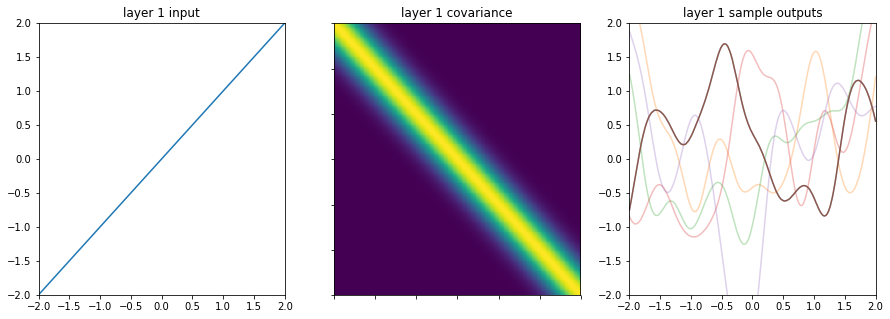

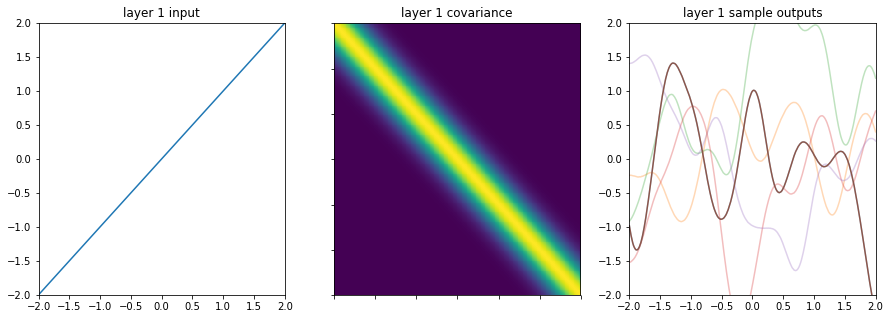

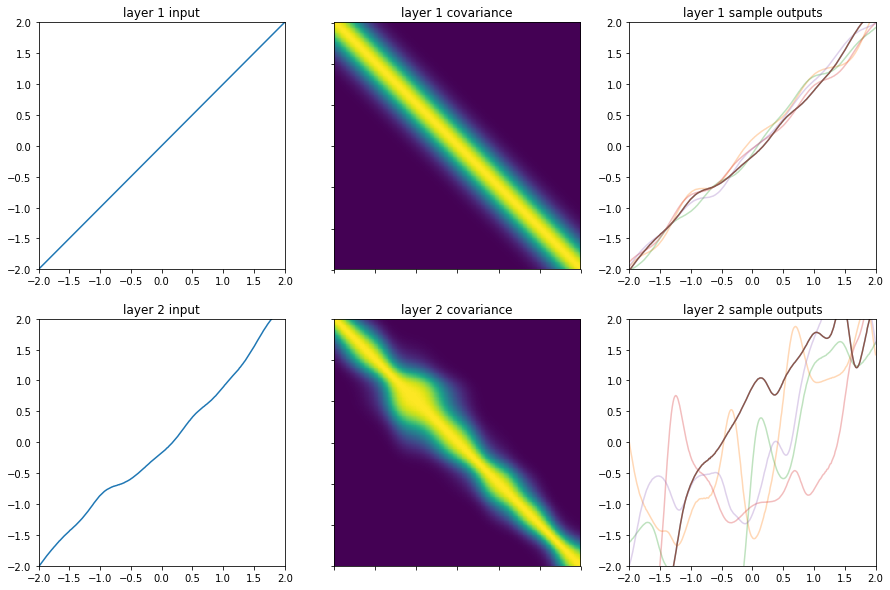

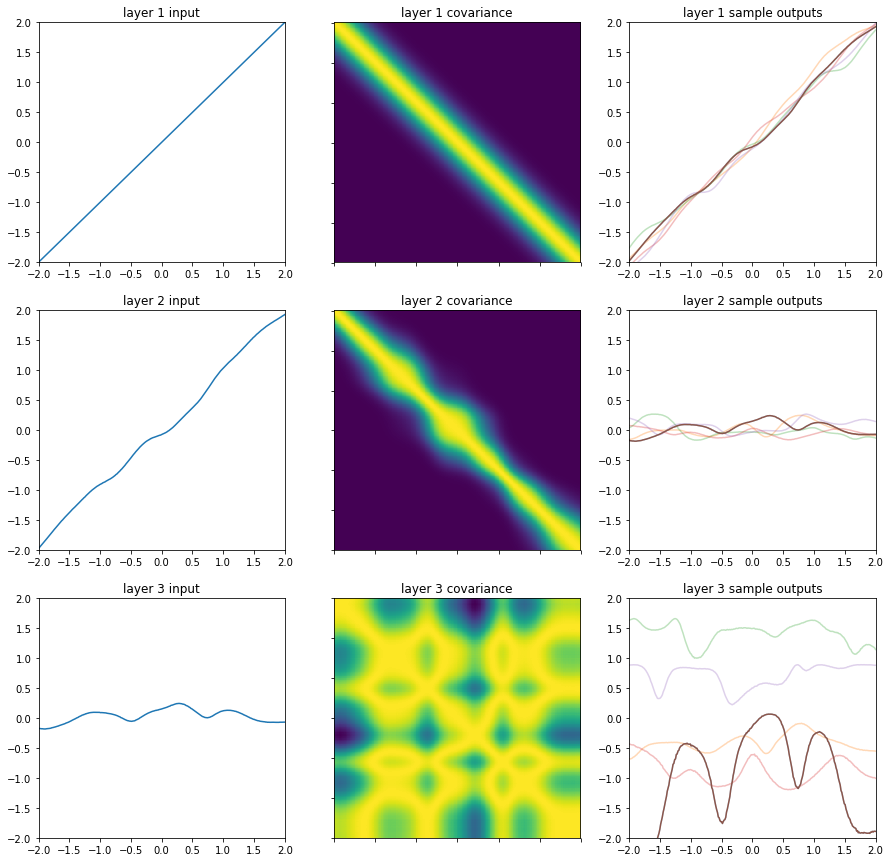

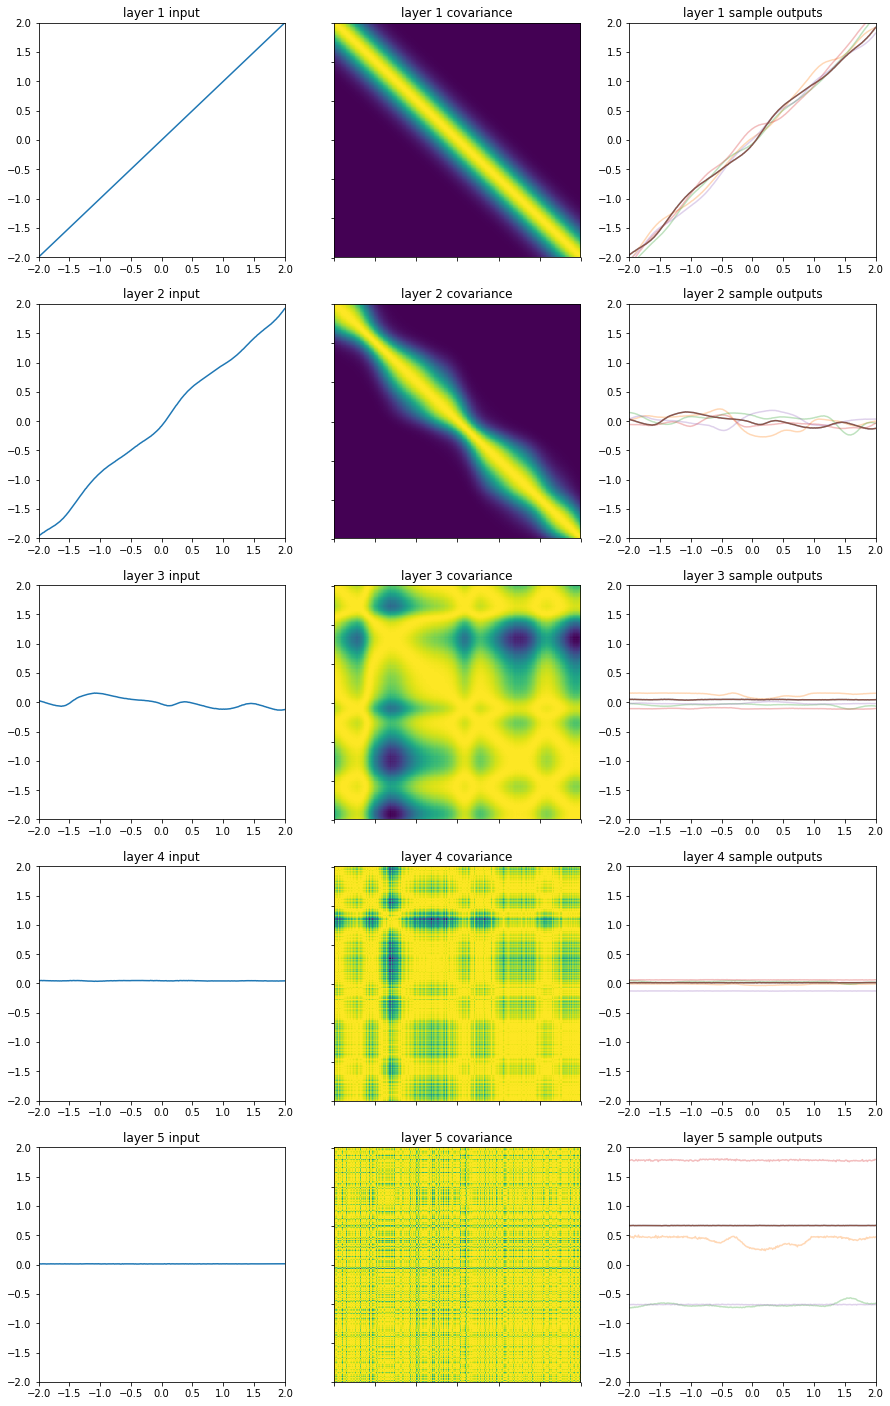

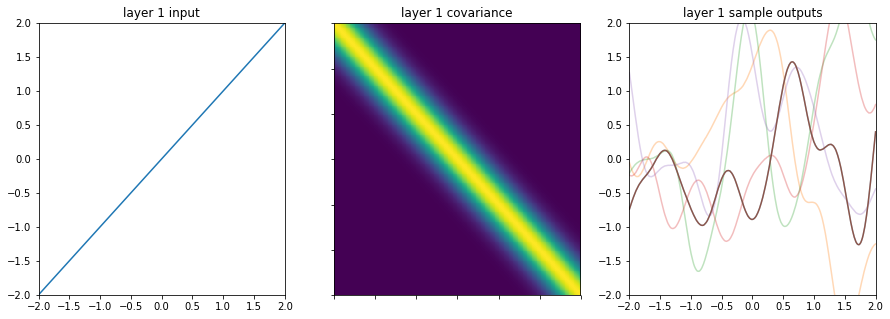

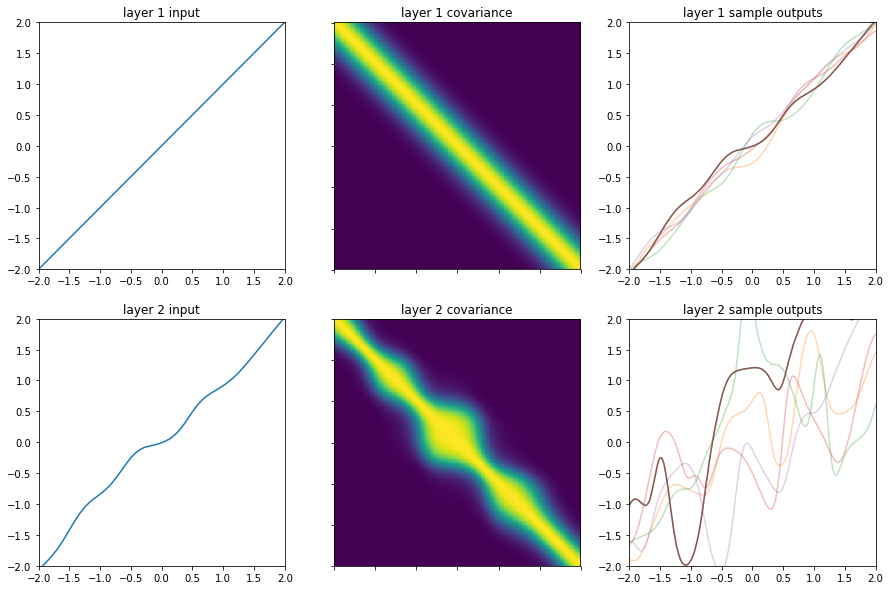

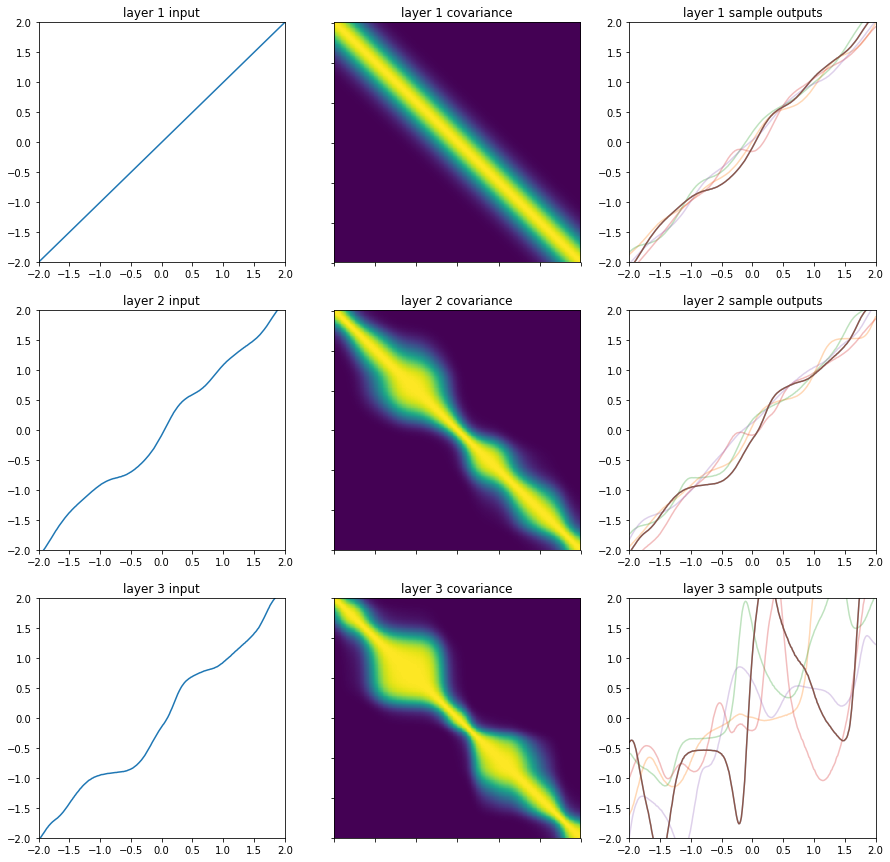

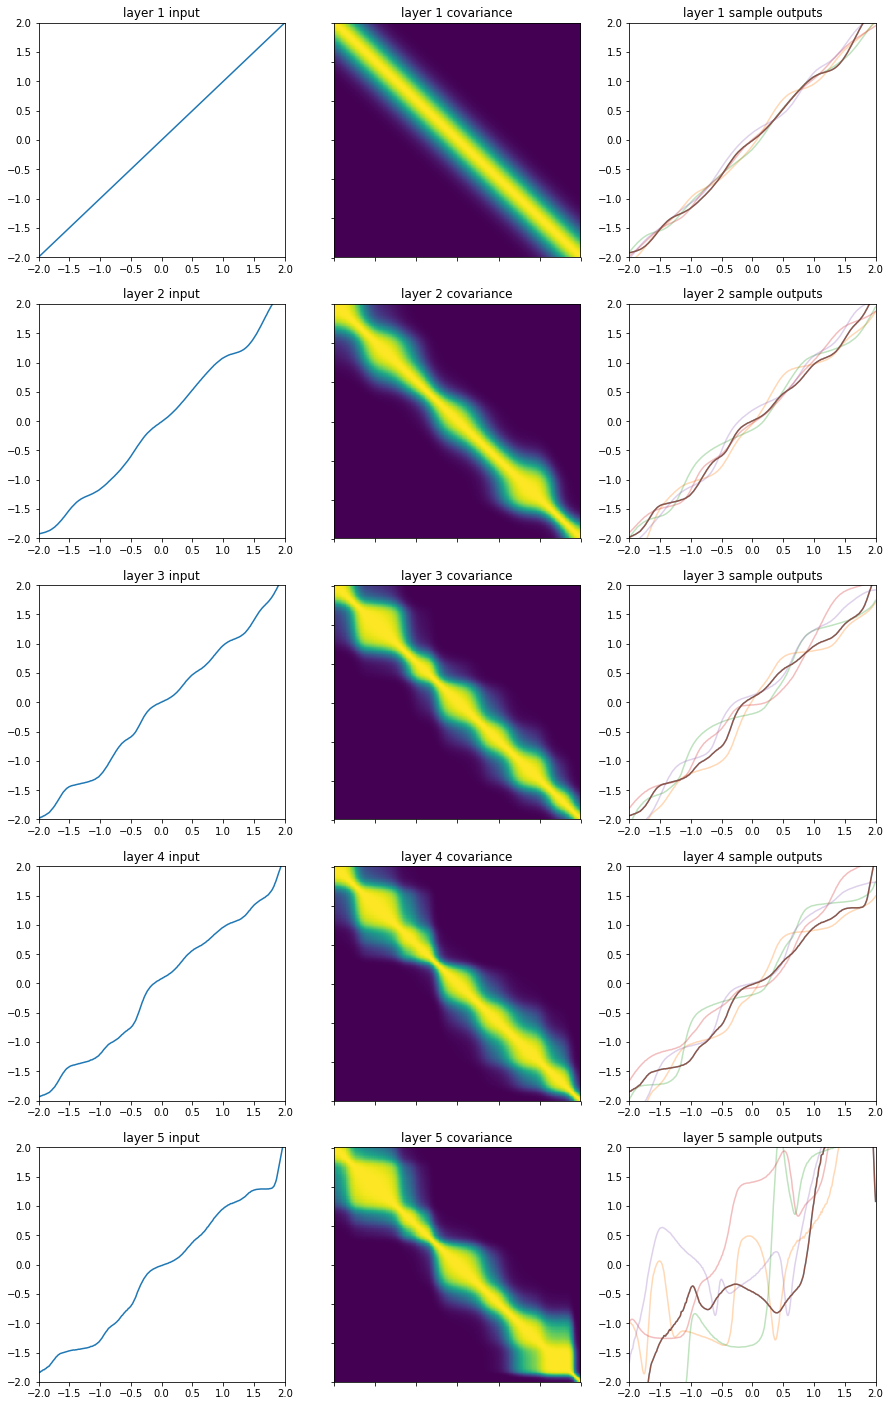

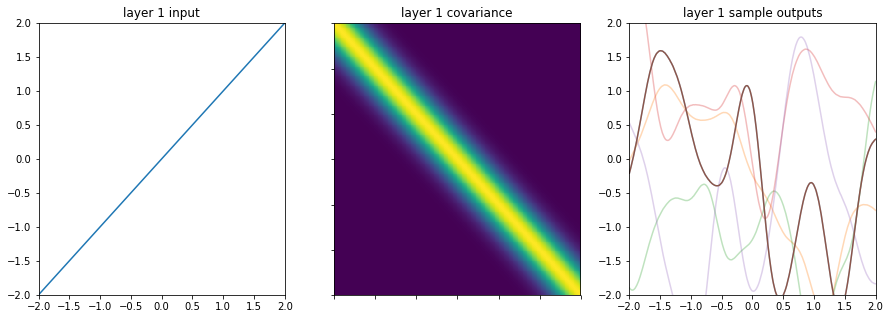

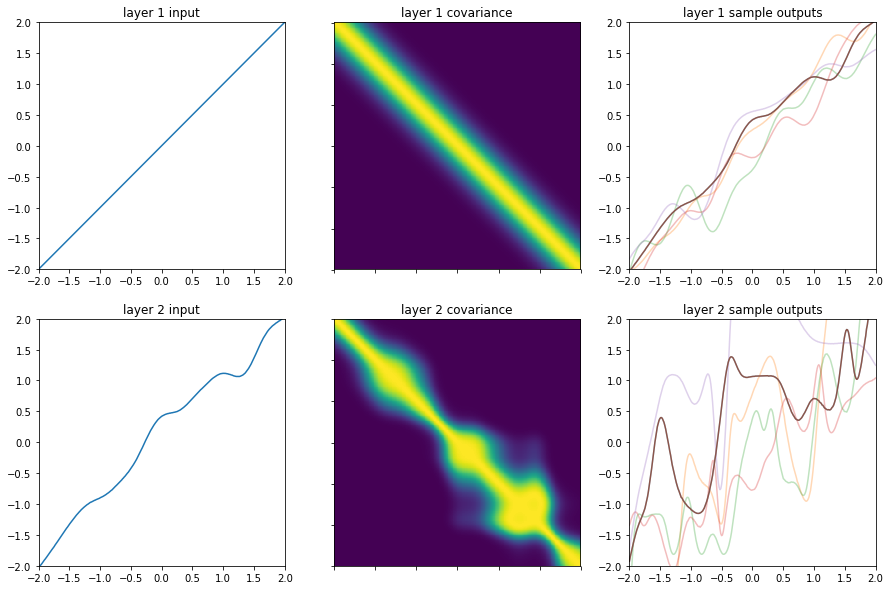

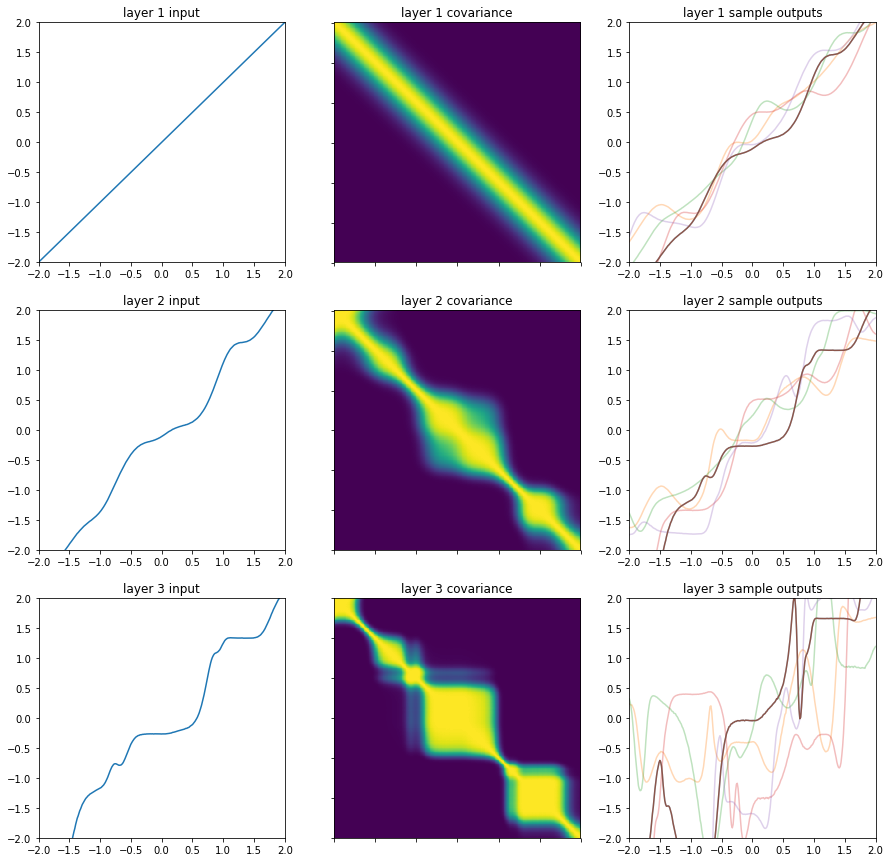

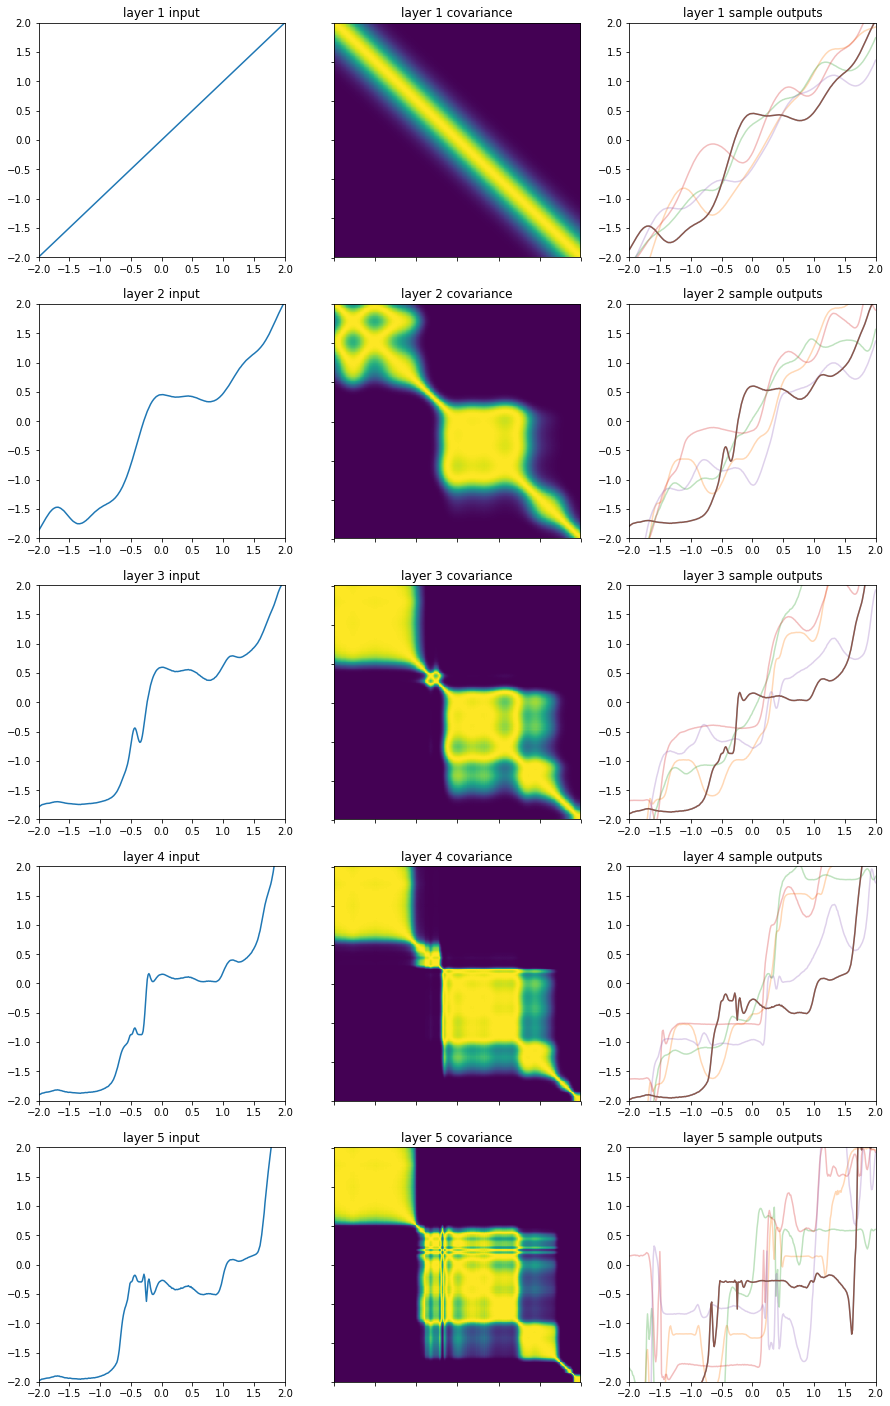

In [12]:
# zero mean function
for m in[m_dgp_2, m_dgp_3, m_dgp_5]:
    for layer in m.layers[:-1]:
        layer.mean_function.A = np.zeros((1, 1))

for m in [m_dgp_1]:
    plot_single_frame(m, name='{}_layer'.format(len(m.layers)))
#     plot_video(m, name='{}_layer'.format(len(m.layers)))

# zero mean function with small outputs
for m in [m_dgp_2, m_dgp_3, m_dgp_5]:
    for layer in m.layers[:-1]:
        layer.kern.variance = 1e-2
        
for m in [m_dgp_1, m_dgp_2, m_dgp_3, m_dgp_5]:
    plot_single_frame(m, name='{}_layer_small'.format(len(m.layers)))
#     plot_video(m, name='{}_layer_small'.format(len(m.layers)))


# identity mean function with small outputs
for m in[m_dgp_2, m_dgp_3, m_dgp_5]:
    for layer in m.layers[:-1]:
        layer.mean_function.A = np.array((1., )).reshape(1, 1)
    
for m in [m_dgp_1, m_dgp_2, m_dgp_3, m_dgp_5]:
    plot_single_frame(m, name='{}_layer_mf_small'.format(len(m.layers)))
#     plot_video(m, name='{}_layer_mf_small'.format(len(m.layers)))

for m in [m_dgp_2, m_dgp_3, m_dgp_5]:
    for layer in m.layers[:-1]:
        layer.kern.variance = 8e-2

            
for m in [m_dgp_1, m_dgp_2, m_dgp_3, m_dgp_5]:
    plot_single_frame(m, name='{}_layer_mf_smallish'.format(len(m.layers)))
#     plot_video(m, name='{}_layer_mf_smallish'.format(len(m.layers)))


In [ ]:
def plot_prior_no_inputs(m, e, axs):
    X, L = m.X.read_value(), len(m.layers)
    Fs, Ks = m.comput()
    
    axs_ = (axs, ) if L == 1 else axs
        
    for i, (F_in, F_out, K, (ax1, ax2), layer) in enumerate(zip([X,]+Fs[:-1], Fs, Ks, axs_, m.layers)):
        ax1.imshow(K, aspect="auto")
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])

        L = np.linalg.cholesky(K + np.eye(N)*1e-6)
        samples = L @ e + layer.compute_mean_function(F_in)
        ax2.plot(samples, alpha=0.3)
        ax2.plot(F_out, color='C0')
        
        ax2.set_ylim(-2, 2)
        
        ax1.set_title('layer {} covariance'.format(i+1))
        ax2.set_title('layer {} sample outputs'.format(i+1))

def setup_fig_no_inputs(m):
    L = len(m.layers)
    fig, axs = plt.subplots(L, 2, figsize=(10, L*5))
    return fig, axs

def plot_single_frame_no_inputs(m, S=5):
    fig, axs = setup_fig_no_inputs(m)
    e = np.random.randn(m.X.shape[0], S)
    plot_prior_no_inputs(m, e, axs)
    plt.show()
    

######################################

def plot_prior_f(m, e, axs):
    X, L = m.X.value, len(m.layers)
    Fs, Ks = m.get_latents_with_K()
    
    axs_ = (axs, ) if L == 1 else axs
        
    for i, (F_in, F_out, K, (ax1, ax2, ax3), layer) in enumerate(zip([X,]+Fs[:-1], Fs, Ks, axs_, m.layers)):
        ax1.plot(X, m.layers[0].kern.f_np(X), color='C0')
        
        ax2.imshow(K, aspect="auto")
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])

        L = np.linalg.cholesky(K + np.eye(N)*1e-6)
        samples = L @ e + layer.compute_mean_function(F_in)
        ax3.plot(X, samples, alpha=0.3)
        ax3.plot(X, F_out, color='C0')
        
        ax3.set_ylim(-2, 2)
        
        ax1.set_title('layer inputs'.format(i+1))
        ax2.set_title('layer {} covariance'.format(i+1))
        ax3.set_title('layer {} sample outputs'.format(i+1))

def plot_single_frame_f(m, S=5, name='test'):
    fig, axs = setup_fig(m)
    e = np.random.randn(m.X.shape[0], S)
    plot_prior_f(m, e, axs)
    plt.savefig("dgp_videos/{}_f.pdf".format(name))
    plt.show()

def plot_single_frame_no_inputs(m, S=5, name='test'):
    fig, axs = setup_fig_no_inputs(m)
    e = np.random.randn(m.X.shape[0], S)
    plot_prior_no_inputs(m, e, axs)
    plt.savefig("dgp_videos/{}_no_inputs.pdf".format(name))
    plt.show()
    
def plot_video_no_inputs(m, S=5, num_frames=num_frames, great_cirlce_its=great_cirlce_its, fps=fps, name='test'):
    gc_e = GreatCircleWithMacKay((m.X.shape[0], S), 120)
    gc_state = GreatCircleWithMacKay((len(m.get_free_state()), 1), 120)
    writer = FFMpegWriter(fps=fps, bitrate=100*fps)
    fig, axs = setup_fig_no_inputs(m)
    
    def make_frame(n):
        e = gc_e.sample()
        m.set_state(gc_state.sample().flatten())
    
        for ax in axs.ravel():
            plt.sca(ax)
            plt.cla()

        plot_prior_no_inputs(m, e, axs)

        plt.draw()
        writer.grab_frame()

    anim = manimation.FuncAnimation(fig, make_frame, frames=num_frames)
    anim.save("dgp_videos/{}.mp4".format(name), writer=writer)

def plot_video_f(m, S=5, num_frames=num_frames, great_cirlce_its=great_cirlce_its, fps=fps, name='test'):
    gc_e = GreatCircleWithMacKay((m.X.shape[0], S), great_cirlce_its)
    gc_state = GreatCircleWithMacKay((len(m.get_free_state()), 1), great_cirlce_its)
    writer = FFMpegWriter(fps=fps, bitrate=100*fps)
    fig, axs = setup_fig(m)
    def make_frame(n):
        e = gc_e.sample()
        m.set_state(gc_state.sample().flatten())
    
        for ax in axs.ravel():
            plt.sca(ax)
            plt.cla()

        plot_prior_f(m, e, axs)

        plt.draw()
        writer.grab_frame()

    anim = manimation.FuncAnimation(fig, make_frame, frames=num_frames)
    anim.save("dgp_videos/{}.mp4".format(name), writer=writer)

In [ ]:
class fRBF(RBF):
    def __init__(self, f_np, *args, **kw):
        RBF.__init__(self, *args, **kw)
        self.f_np = f_np
        
    def K(self, X, X2=None):
        X_ = tf.py_func(self.f_np, [X], tf.float64)
        if X2 is None:
            X2_ = None
        else:
            X2_ = tf.py_func(self.f_np, [X2], tf.float64)
        return RBF.K(self, X_, X2_)

In [ ]:
N = 300
X = np.linspace(-2, 2, N).reshape(-1, 1)
Y = np.zeros((N, 1))

fs, names = [], []


fs.append(lambda x: x); names.append('single_layer_rbf')
fs.append(lambda x: np.exp(x)); names.append('single_layer_exp')
fs.append(lambda x: x**2); names.append('single_layer_quad')


def f1_np(X):
    ret = []
    for x in X:
        if x < 0:
            ret.append(0.5*x)
        elif x < 1:
            ret.append(3*x)
        else:
            ret.append(x + 2)
    return np.array(ret).reshape(X.shape)

fs.append(f1_np); names.append('single_layer_three_speed')

def f2_np(X):
    ret = []
    for x in X:
        if x < 0:
            ret.append(x)
        else:
            ret.append(x + 2.)
    return np.array(ret).reshape(X.shape)

fs.append(f2_np); names.append('single_layer_independent_chunks')

def f3_np(X):
    ret = []
    for x in X:
        if x < 0:
            ret.append(x)
        else:
            ret.append(x-2)
    return np.array(ret).reshape(X.shape)

fs.append(f3_np); names.append('single_layer_repeating')


def f4_np(X):
    ret = []
    for x in X:
        if x < 0:
            ret.append(x)
        elif x<1:
            ret.append(x*0. + 2)
        else:
            ret.append(x - 1. - 2)
    return np.array(ret).reshape(X.shape)

fs.append(f4_np); names.append('single_layer_constant_patch')

fs.append(lambda x: np.sin(x)); names.append('single_layer_sin')

fs.append(lambda x: np.sin(5*x)); names.append('single_layer_sin5')


ms = []
for f in fs:
    kern = [fRBF(f, 1, lengthscales=0.3)]
    ms.append(DGP_HMC(X, Y, kern, Gaussian_lik()))

for m in ms:
    for layer in m.layers:
        layer.kern.fixed = True
    m.likelihood.fixed = True
    m.randomize()

for m, name in zip(ms, names):
    plot_single_frame_no_inputs(m, name=name)    
    plot_single_frame_f(m, name=name)

    plot_video_no_inputs(m, name=name)
    plot_video_f(m, name='{}_f'.format(name))

In [ ]:
class NN(Model):
    def __init__(self, X, Y, activation, model_name):
        self.model_name = model_name
        Model.__init__(self)
        N, D = X.shape
        _, DY = Y.shape
        
        self.W1 = Param(np.zeros((D, 100)))
        self.W2 = Param(np.zeros((100, 100)))
        self.W3 = Param(np.zeros((100, DY)))
        
        self.b1 = Param(np.zeros((100)))
        self.b2 = Param(np.zeros((100)))
        self.b3 = Param(np.zeros((DY)))
    
        self.W1.prior = Gaussian_prior(0., 1.)
        self.W2.prior = Gaussian_prior(0., 1.)
        self.W3.prior = Gaussian_prior(0., 1.)
        
        self.b1.prior = Gaussian_prior(0., 1.)
        self.b2.prior = Gaussian_prior(0., 1.)
        self.b3.prior = Gaussian_prior(0., 1.)
        
        self.activation = activation
        self.X = X
        self.Y = Y
        
    def forward(self):
        s = self.activation
        return s(s(X @ self.W1 + self.b1) @ self.W2 + self.b2) @ self.W3 + self.b3
    
    @AutoFlow()
    def compute_forward(self):
        return self.forward()

In [ ]:
def plot_video_nn(m, S=5, num_frames=num_frames, great_cirlce_its=great_cirlce_its, fps=fps, name='test'):
    
    gc_state = GreatCircleWithMacKay((S, len(m.get_free_state())), great_cirlce_its)
    writer = FFMpegWriter(fps=fps, bitrate=100*fps)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    def make_frame(n):
        plt.sca(ax)
        plt.cla()
        
        ax.set_xlim(min(m.X), max(m.X))
        ax.set_ylim(-100, 100)
        
        for i, e in enumerate(gc_state.sample()):
            m.set_state(e)
            if i == 0:
                ax.plot(m.X, m.compute_forward(), alpha=1.)
            else:
                ax.plot(m.X, m.compute_forward(), alpha=0.2)
        plt.draw()
        writer.grab_frame()

    anim = manimation.FuncAnimation(fig, make_frame, frames=num_frames)
    anim.save("dgp_videos/{}.mp4".format(name), writer=writer)

def plot_single_frame_nn(m, S=5, name='test'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for i, e in enumerate(np.random.randn(S, len(m.get_free_state()))):
        m.set_state(e)
        if i == 0:
            ax.plot(m.X, m.compute_forward(), alpha=1.)
        else:
            ax.plot(m.X, m.compute_forward(), alpha=0.2)
                
    plt.savefig("dgp_videos/{}.pdf".format(name))
    plt.show()

In [ ]:
X = np.linspace(-2, 5, N).reshape(N, 1)

nn_relu = NN(X, Y, tf.nn.relu, 'relu')
nn_sigmoid = NN(X, Y, tf.nn.sigmoid, 'sigmoid')
nn_tanh = NN(X, Y, tf.nn.tanh, 'tanh')

nns = [nn_relu, nn_sigmoid, nn_tanh]
for nn in nns:
    nn.randomize()

In [ ]:
for nn in nns:
    plot_video_nn(nn, name='nn_{}'.format(nn.model_name))
    plot_single_frame_nn(nn, name='nn_{}'.format(nn.model_name))

In [ ]:
plt.show()

def compute_cov(m):
    S = []
    for _ in range(10000):
        m.randomize()
        S.append(m.compute_forward())

    S = np.array(S)
    cov = np.cov(S[:, :, 0].T)
    mean = np.average(S[:, :, 0], 0)
    
    return mean, cov

means, covs = [], []
for nn in nns:
    m, v = compute_cov(nn)
    means.append(m)
    covs.append(v)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for m, v, ax, nn in zip(means, covs, axs, nns):
    a = ax.matshow(v)
    fig.colorbar(a, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(nn.model_name)

plt.savefig('dgp_videos/covs.pdf')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for m, v, ax, nn in zip(means, covs, axs, nns):
    a = ax.matshow(np.log(v))
    fig.colorbar(a, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(nn.model_name)
    
plt.savefig('dgp_videos/covs_log.pdf')
plt.show()

In [ ]:
from gpflow.gpr import GPR

In [ ]:
N, Ns = 30, 300
X = np.linspace(0, 1, N).reshape(N, 1)
Y1 = np.sin(10*X**3)
Y2 = np.sin(10*(1-X)**3)


Xs = np.linspace(0., 1., Ns).reshape(-1, 1)

plt.scatter(X, Y1)
plt.show()


plt.scatter(X, Y2)
plt.show()

In [ ]:
m1 = GPR(X, Y1, fRBF(lambda x: x, 1, lengthscales=0.2))
m1.likelihood.variance = 1e-2

m2 = GPR(X, Y1, fRBF(lambda x: np.exp(x**2), 1, lengthscales=0.2))
m2.likelihood.variance = 1e-2

m3 = GPR(X, Y2, fRBF(lambda x: np.exp(x**2), 1, lengthscales=0.2))
m3.likelihood.variance = 1e-2

m4 = GPR(X, Y2, fRBF(lambda x: np.exp((1-x)**2), 1, lengthscales=0.2))
m4.likelihood.variance = 1e-2

def plot_meanvar_with_prior_cov(model, name):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.set_title('prior cov')
    ax2.set_title('prior samples')
    ax3.set_title('posterior')
    
    K = model.kern.compute_K_symm(Xs)
    ax1.imshow(K, aspect="auto")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    
    L = np.linalg.cholesky(K + np.eye(Ns)*jitter_level)
    samples = L @ np.random.randn(Ns, 5)
    ax2.plot(Xs.flatten(), samples, alpha=1.)
#     ax3.plot(X, F_out, color='C0')
        
    mean, var = model.predict_f(Xs)
    
    ax3.scatter(model.X.value, model.Y.value, marker='x', color='k')
    ax3.plot(Xs, mean, color='b')
    l, u = [mean.flatten() + s * var.flatten()**0.5 for s in [1.96, -1.96]]
    ax3.fill_between(Xs.flatten(), l, u, color='b', alpha=0.2)
    plt.savefig('dgp_videos/{}.pdf'.format(name))
    plt.show()
    
plot_meanvar_with_prior_cov(m1, 'post_iso_cov')

plot_meanvar_with_prior_cov(m2, 'post_correct_cov')

plot_meanvar_with_prior_cov(m3, 'post_mis_cov')

plot_meanvar_with_prior_cov(m4, 'post_mis_cov_backwards')

In [ ]:
from doubly_stochastic_dgp.dgp import DGP
import tensorflow as tf
from gpflow.kernels import White 

m_dgp_1 = DGP(X, Y1, X.copy(), [RBF(1, lengthscales=0.2, variance=0.1) + White(1, variance=1e-5),
                                RBF(1, lengthscales=0.2, variance=1)+ White(1, variance=1e-5)],
              Gaussian_lik())
m_dgp_1.likelihood.varince = 1e-2


m_dgp_2 = DGP(X, Y2, X.copy(), [RBF(1, lengthscales=0.2, variance=0.1) + White(1, variance=2e-6),
                                RBF(1, lengthscales=0.2, variance=1)+ White(1, variance=2e-6)],
              Gaussian_lik())
m_dgp_2.likelihood.varince = 1e-2


for layer in m_dgp_1.layers:
    layer.kern.fixed = True
    layer.mean_function.fixed = True
    

for layer in m_dgp_2.layers:
    layer.kern.fixed = True
    layer.mean_function.fixed = True
    
    
m_dgp_1.optimize(tf.train.AdamOptimizer(0.01), maxiter=1000)
m_dgp_2.optimize(tf.train.AdamOptimizer(0.01), maxiter=1000)

In [ ]:
def plot_DGP(m, name):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(m.X.value, m.Y.value, marker='x', color='k')
    
    for _ in range(50):
        mean, var = m.predict_f_full_cov(Xs)
        s = np.random.multivariate_normal(mean.flatten(), var.reshape(Ns, Ns))
        ax.plot(Xs, s, c='b', alpha=0.05)
        
    plt.savefig('dgp_videos/{}.pdf'.format(name))
    plt.show()

plot_DGP(m_dgp_1, 'dgp_1')
plot_DGP(m_dgp_2, 'dgp_2')